In [0]:
# Imports section
import torch, torchvision, PIL, json
import matplotlib.pyplot as plt
import numpy as np, os, seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn, optim

In [2]:
# uninstall older PIL version
!pip uninstall -y Pillow
# install the new one
!pip install Pillow
# check Pillow version
# restart might be needed to use the new version
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1
  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


5.4.1


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# If CUDA is not available, it can be enabled from 
# Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

CUDA is available!  Training on GPU ...


In [4]:
# Download the Flower Dataset from https://www.kaggle.com/lenine/flower-102diffspecies-dataset
# Also, the category to name json file
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [0]:
# Set the training and validation directories
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

# Paramns
scale = 256
input_shape = 224
mean = [0.485, 0.456, 0.406] # ImageNet parameters
std = [0.229, 0.224, 0.225] # ImageNet parameters
batch_size = 32

In [0]:
# Define the transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(input_shape),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(hue=.05, saturation=.05),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])
valid_transforms = transforms.Compose([transforms.Resize(scale),
                                      transforms.CenterCrop(input_shape),
                                      transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])

In [0]:
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

In [0]:
# Define the dataloaders using the image datasets and the trainforms
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

In [0]:
# Define a method to check the images from the dataloaders
def imshow(img):
  plt.figure(figsize=(25,15))
  img=img.numpy()
  img[0,:,:]=img[0,:,:]*0.229+0.485
  img[1,:,:]=img[1,:,:]*0.224+0.456
  img[2,:,:]=img[2,:,:]*0.225+0.406
  plt.imshow(np.transpose(img,(1,2,0)))

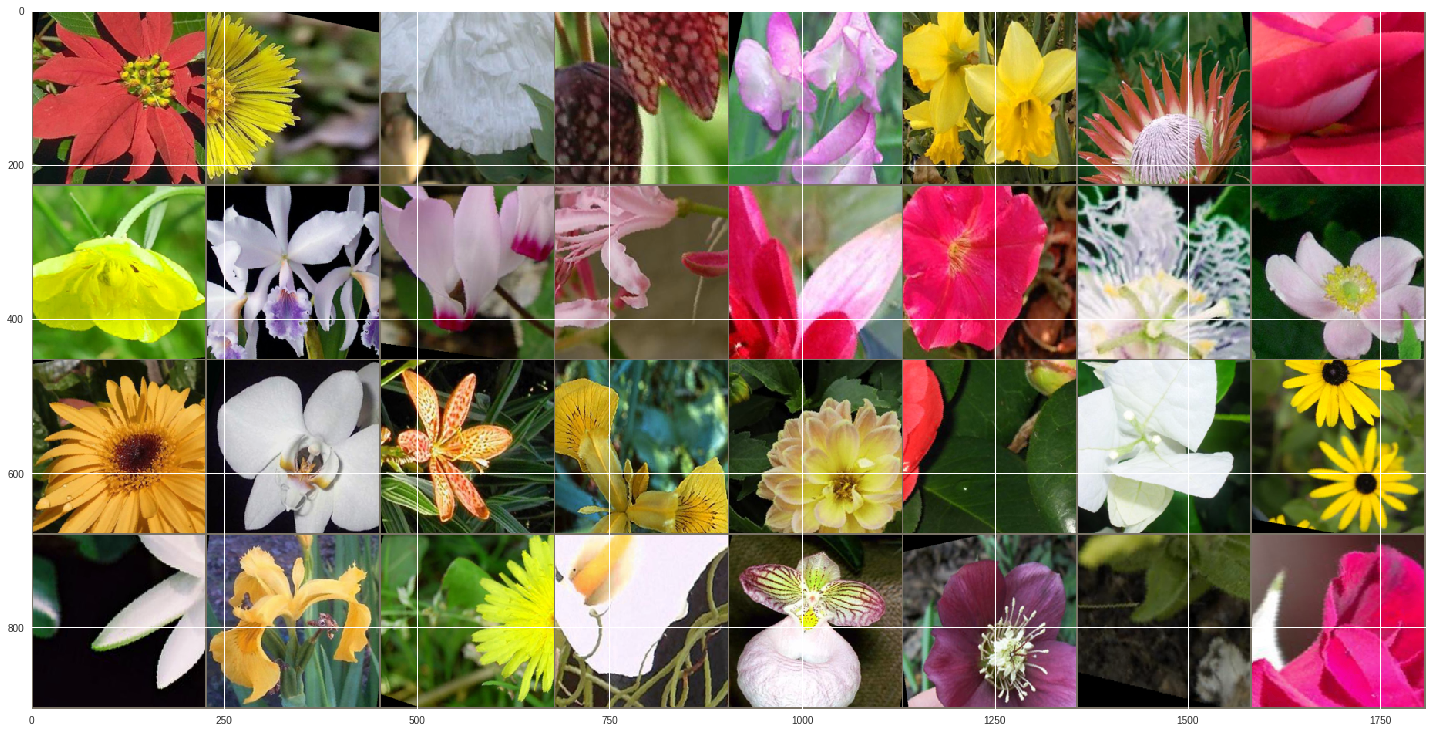

In [55]:
# Check the trainloader data
# TODO: Reposition the grid so that it splits the images
images,labels=next(iter(trainloader))
img=torchvision.utils.make_grid(images[:32])
imshow(img)

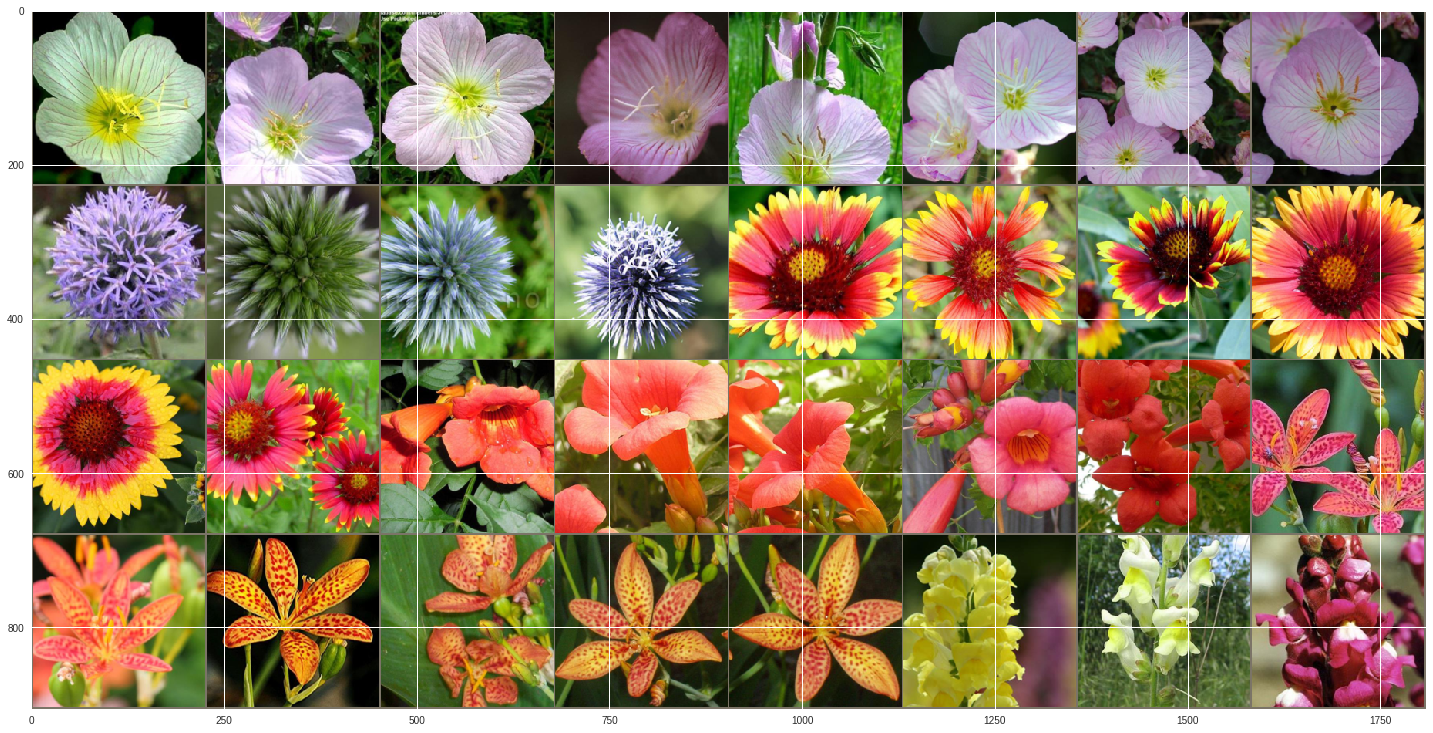

In [56]:
# Check the validloader data
# TODO: Reposition the grid so that it splits the images
images,labels=next(iter(validloader))
img=torchvision.utils.make_grid(images[:32])
imshow(img)

In [0]:
# Import category to name JSON data
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# Load a pretrained model of your choice from torchvision.models
model = models.resnet152(pretrained=True)

# Check model architecture so you can define your new classifier
print(model)

In [0]:
# Define a new untrained feed-forward classifier, using ReLu activations and droptout
# Keep input features at 2048, change output features from 1000 to 102 (# of flower categories)

model.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 102),
                            nn.LogSoftmax(dim=1))

# Map classes to indices to be used for Inference
model.class_to_idx = train_data.class_to_idx

# Check model with the new fc classifier
print(model)

In [0]:
# Image Preprocessing
# Scales, crops, and normalizes a PIL image for a PyTorch model, returns an Numpy array

def process_image(image_path):

  # Open the image
  from PIL import Image
  img = Image.open(image_path)
  
  # Resize
  if img.size[0] > img.size[1]:
    img.thumbnail((10000, 256))
  else:
    img.thumbnail((256, 10000))
    
  # Crop 
  left_margin = (img.width-224)/2
  bottom_margin = (img.height-224)/2
  right_margin = left_margin + 224
  top_margin = bottom_margin + 224
  img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
  # Normalize
  img = np.array(img)/256
  img = (img - mean)/std
    
  # Move color channels to first dimension as expected by PyTorch
  img = img.transpose((2, 0, 1))
    
  return img

In [0]:
# Convert Pytorch tensor and display it

def imshow(image, ax=None, title=None):

  # aesthetics configuration
  if ax is None:
    fig, ax = plt.subplots();
  if title:
    plt.title(title);
    
  # PyTorch tensors assume the color channel is first
  # but matplotlib assumes is the third dimension
  image = image.transpose((1, 2, 0))
    
  # Undo preprocessing
  image = std * image + mean
    
  # Image needs to be clipped between 0 and 1
  image = np.clip(image, 0, 1)
    
  ax.imshow(image);
    
  return ax

In [0]:
# Predict top(5) class probabilities using the model

def predict(image_path, model, top_num=5):

    # Process image
    img = process_image(image_path)
    
    # Model activation for the eval mode
    model.eval()
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # CPU transfer
    image_tensor.to('cpu')
    model_input.to('cpu')
    model.to('cpu')
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
# Plot the image with the title and probabilities for the top 5 classes as a bar graph

def plot_solution(image_path, model):
    
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Set up title
    flower_num = image_path.split('/')[2] 
    title_ = cat_to_name[str(flower_num)] 
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    # Plot bar chart
    plt.subplot(2,1,2);
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show();

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


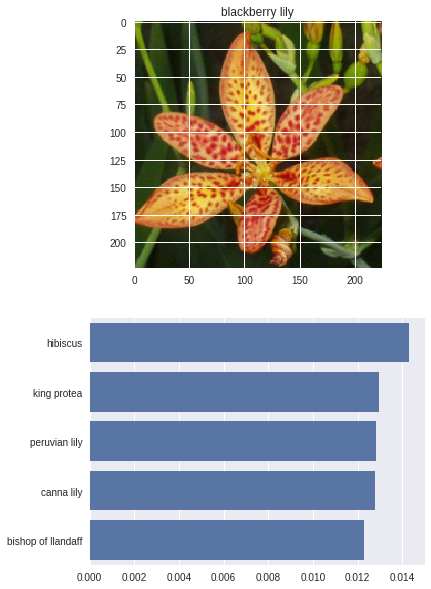

In [79]:
# Test the model before training the Classifier

image_path = os.path.join(valid_dir, '102/image_08040.jpg')
plot_solution(image_path, model)

In [0]:
# Freeze all model parameters except the untrained newly created classifier
for param in model.parameters():
    param.requires_grad = False
   
for param in model.fc.parameters():
    param.requires_grad = True

In [0]:
# Define the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [0]:
# Set the device on which the training will be performed: cuda or cpu
# If cuda is available it's best to use it to improve trainig speed by over 100x
device=torch.device(("cuda") if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [0]:
# Train the model's classifier
epochs = 100
steps = 0
training_loss = 0
print_every = 20
valid_loss_min = np.Inf
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the device
        inputs, labels = inputs.to(device), labels.to(device)    
        optimizer.zero_grad()
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        # Validate model and print results after print_every number of steps
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            valid_loss = valid_loss/len(validloader)
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {training_loss/print_every:.3f}.. "
                  f"Test loss: {valid_loss:.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            # Save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                model.class_to_idx = train_data.class_to_idx
                torch.save({
                  'arch':'resnet152',
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'validation_accuraccy': {accuracy/len(validloader)},
                  'class_to_idx': model.class_to_idx,
                  'validation_loss': {valid_loss},
                  'train_loss': {training_loss/print_every},
                  }, 'checkpoint.pth')
                valid_loss_min = valid_loss
            training_loss = 0
            model.train()

In [0]:
# Define a method for loading the checkpoint and rebuilding the model
def load_checkpoint(checkpoint_file):
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'], strict=False)
  model.class_to_idx = checkpoint['class_to_idx']
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
# Load the saved checkpoint for further training or inference
load_checkpoint('checkpoint.pth')